# Table of Contents

- #### [Imports and data overview](#overview)
    - ####   View static dataset
    - #### Working with Dynamic dataset


### Imports and SparkSession creation

In [140]:
import pandas as pd 
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, count, avg, round, stddev
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
import tensorflow as tf 

#For One Hot Encoding:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#For visualizing distributions
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [10]:
spark = SparkSession.builder.master("local").appName("health").getOrCreate()

In [40]:
spark.sparkContext.setLogLevel("ERROR")

### Get and initially view static Dataset

In [104]:
df = spark.read.csv("health_data_static/gym_members_exercise_tracking.csv", inferSchema=True, header=True)
#Let's view head(3), to see what the dataset we have in question
df.show(n=3)
#Number of rows:
print(f"static number of rows: {df.count()}")

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT|          33.9|                  2.1|              

In [95]:
#Count # of Nulls:
#We will not need to worry about transforming out dataset to take care of nulls
df.select([count(when(isnan(col), col)).alias(f"{col}_null") for col in df.columns]).show()

+--------+-----------+----------------+---------------+------------+------------+----------------+-----------------------------+--------------------+-----------------+-------------------+--------------------------+----------------------------------+---------------------+--------+
|Age_null|Gender_null|Weight (kg)_null|Height (m)_null|Max_BPM_null|Avg_BPM_null|Resting_BPM_null|Session_Duration (hours)_null|Calories_Burned_null|Workout_Type_null|Fat_Percentage_null|Water_Intake (liters)_null|Workout_Frequency (days/week)_null|Experience_Level_null|BMI_null|
+--------+-----------+----------------+---------------+------------+------------+----------------+-----------------------------+--------------------+-----------------+-------------------+--------------------------+----------------------------------+---------------------+--------+
|       0|          0|               0|              0|           0|           0|               0|                            0|                   0|        

View more info as aggregate via PySpark functions

In [114]:
df.groupBy("Gender", "Workout_Type").agg( round(avg("Resting_BPM"),1).alias("Average Resting Hear Rate (BPM)"), round(avg("BMI"),1).alias("Average BMI")).show()

+------+------------+-------------------------------+-----------+
|Gender|Workout_Type|Average Resting Hear Rate (BPM)|Average BMI|
+------+------------+-------------------------------+-----------+
|  Male|        Yoga|                           61.8|       26.5|
|Female|      Cardio|                           61.8|       23.0|
|Female|        Yoga|                           61.8|       22.0|
|Female|        HIIT|                           63.0|       22.8|
|  Male|      Cardio|                           62.1|       27.7|
|  Male|        HIIT|                           62.4|       27.4|
|Female|    Strength|                           62.0|       22.9|
|  Male|    Strength|                           62.9|       26.0|
+------+------------+-------------------------------+-----------+



Initially it looks like Females who do Yoga have the lowest BMI and Resting Heart Rate. However, the resting heart rates seem to have very little variation. Let's check it as a distribution and standard devation.

In [135]:
df.select( stddev("Resting_BPM"), stddev("BMI")).show()

+------------------------+-----------------+
|stddev_samp(Resting_BPM)| stddev_samp(BMI)|
+------------------------+-----------------+
|       7.327059908996752|6.660879393631095|
+------------------------+-----------------+



Now we will use SNS to view the distribution

In [121]:
df_bpm_bmi = df.select( col("Resting_BPM"), df.BMI).toPandas(['Resting'])
df_bpm_bmi.head(4)

,Resting_BPM,BMI
0,60,30.20
1,66,32.00
2,54,24.71
3,56,18.41


In [125]:
df_bpm_bmi.describe()

,Resting_BPM,BMI
count,973.000000,973.000000
mean,62.223022,24.912127
std,7.327060,6.660879
min,50.000000,12.320000
25%,56.000000,20.110000
50%,62.000000,24.160000
75%,68.000000,28.560000
max,74.000000,49.840000


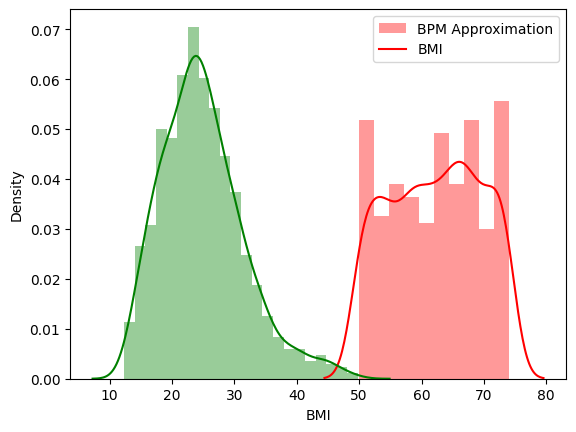

In [156]:
#Let's check the distribution
sns.distplot(df_bpm_bmi['Resting_BPM'], color="red", label="BPM"), sns.distplot(df_bpm_bmi['BMI'], color = "green", label="BMI")

plt.legend(labels=['BPM Approximation', 'BMI'])
plt.show()

The distribution of the resting heart rate is non-normal. I will assume that there is something wrong with the methodology, data, or the sample is too small. Regardless, we will proceed.

### Goal
From first glance, it appears that Workout_Type and Gender should be one-hot encoded.
The greatest measure of health in my opinion is Resting Heart rate, so let's build a model that attempts to solve for it.

## Sample Streaming Process

In [100]:
#Howerver, let's assume we're working with a dynamic stream. In this case, we choose to append, assuming new additions may be added
schema = StructType( [
    StructField("Age", IntegerType(), True),                StructField("Gender", StringType(), True),
    StructField("Weight_(kg)", FloatType(), True),          StructField("Height_(m)", FloatType(), True),
    StructField("Max_BPM", IntegerType(), True),            StructField("Avg_BPM", IntegerType(), True),
    StructField("Resting_BPM", IntegerType(), True),        StructField("Session_Duration_(hours)", FloatType(), True), 
    StructField("Calories_Burned", FloatType(), True),      StructField("Workout_Type", StringType(), True),
    StructField("Fat_Percentage", FloatType(), True),       StructField("Water_Intake_(liters)", FloatType(), True),
    StructField("Workout_Frequency_(days/week)", IntegerType(), True),
    StructField("Experience_Level", IntegerType(), True),   StructField("BMI", FloatType(), True)
])

df = spark.readStream.schema(schema).csv("health_data")

### Let's view by batch:

Although our streaming directory has two separate data files, the stream consolidates them into one.

In [85]:
def show_head_and_shape(batch_df, batch_id):
    print("2")
    print(f"batch {batch_id} has {batch_df.count()} rows")
    batch_df.show(n=1)
    print("\n")

query = df.writeStream.foreachBatch(show_head_and_shape).start()

One Hot Encoding the inputs. As discussed, Gender and Workout Type should be one hot encoded. To do this, we initially have to apply a StringIndexer as OHE in this case needs to work with numerical values

In [101]:

indexer_gender = StringIndexer(inputCol = "Gender", outputCol="Gender_Index")
ohe_gender = OneHotEncoder(inputCol = "Gender_Index", outputCol = "Gender_Encoded")
pipeline = Pipeline(stages=[indexer_gender, ohe_gender])
#model = pipeline.fit(df)
#
df = indexer.fit(df).transform(df)

AnalysisException: Queries with streaming sources must be executed with writeStream.start();
FileSource[health_data]

In [99]:
df.show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+------------+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|Gender_Index|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+------------+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|         0.0|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT

In [81]:
#Show first rows
query = df.writeStream.outputMode("append").format("console").start()

-------------------------------------------
Batch: 0
-------------------------------------------
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight_(kg)|Height_(m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration_(hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake_(liters)|Workout_Frequency_(days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|        

In [45]:
df.count()

AnalysisException: Queries with streaming sources must be executed with writeStream.start();
FileSource[health_data]

In [7]:
df.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Weight (kg): string (nullable = true)
 |-- Height (m): string (nullable = true)
 |-- Max_BPM: string (nullable = true)
 |-- Avg_BPM: string (nullable = true)
 |-- Resting_BPM: string (nullable = true)
 |-- Session_Duration (hours): string (nullable = true)
 |-- Calories_Burned: string (nullable = true)
 |-- Workout_Type: string (nullable = true)
 |-- Fat_Percentage: string (nullable = true)
 |-- Water_Intake (liters): string (nullable = true)
 |-- Workout_Frequency (days/week): string (nullable = true)
 |-- Experience_Level: string (nullable = true)
 |-- BMI: string (nullable = true)



# Overview

In [31]:
[x for x in [1,2,4]]+ [x for x in [4,5,6]]

[1, 2, 4, 4, 5, 6]

In [33]:
[ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]

[StructField('Workout_Type', StringType(), True),
 StructField('Gender', StringType(), True),
 StructField('Age', IntegerType(), True),
 StructField('Weight (kg)', IntegerType(), True),
 StructField('Height (m)', IntegerType(), True),
 StructField('Max_BPM', IntegerType(), True),
 StructField('Avg_BPM', IntegerType(), True),
 StructField('Resting_BPM', IntegerType(), True),
 StructField('Session_Duration (hours)', IntegerType(), True),
 StructField('Calories_Burned', IntegerType(), True),
 StructField('Fat_Percentage', IntegerType(), True),
 StructField('Water_Intake (liters)', IntegerType(), True),
 StructField('Workout_Frequency (days/week)', IntegerType(), True),
 StructField('Experience_Level', IntegerType(), True),
 StructField('BMI', IntegerType(), True)]

In [43]:
#Make into ints/strings
"""
columns = df.columns
string_columns = ['Workout_Type', 'Gender']
schema = StructType(
    [ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]
)
"""

"\ncolumns = df.columns\nstring_columns = ['Workout_Type', 'Gender']\nschema = StructType(\n    [ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]\n)\n"

Count NULLs. There are none.

In [13]:
df.select([count( when( isnan(c), c)).alias(c) for c in df.columns]).show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|  0|     0|          0|         0|      0|      0|          0|                       0|              0|           0|             0|                    0|                            0|               0|  0|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+----------------------

In [22]:
#Save table to catalog
df.write.saveAsTable("health_data")
#Read catalog 
print(spark.catalog.listTables())

[Table(name='health_data', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]


In [28]:
temp_df = spark.sql("select _c1, _c2 from health_data limit 3")

In [ ]:
# Count the number of nulls in each column of the dataframe
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

In [25]:
#df.select("Age", "Weight (kg)", "Height (m)").show()
#df.groupBy("Age").count().show()
df.filter(df["Age"]==47).show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 47|Female|       66.8|      1.75|    199|    146|         56|                    1.13|          742.0|    Strength|          32.8|                  2.5|                            3|               2|21.81|
| 47|Female|       58.5|      1.79|    195|    131|         71|                    1.42|          837.0|        Yoga|          30.3|                  2.4|              

As one can see, the columns are set arbitrarily.
Instead, we want to set the first row to the column names

In [30]:
temp_df.toPandas()

,_c1,_c2
0,Gender,Weight (kg)
1,Male,88.3
2,Female,74.9


24/11/19 02:18:27 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 911560 ms exceeds timeout 120000 ms
24/11/19 02:18:27 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/19 02:18:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc

In [13]:
row_1 = df.collect()[0]

In [14]:
row_1

Row(_c0='Age', _c1='Gender', _c2='Weight (kg)', _c3='Height (m)', _c4='Max_BPM', _c5='Avg_BPM', _c6='Resting_BPM', _c7='Session_Duration (hours)', _c8='Calories_Burned', _c9='Workout_Type', _c10='Fat_Percentage', _c11='Water_Intake (liters)', _c12='Workout_Frequency (days/week)', _c13='Experience_Level', _c14='BMI')